London was built in xxxx by the roman empire and is a city rich in history and geographical diversity. It has seen wars, plagues, fires and most recently a virus pandemic. ...

In this analysis, I will extract the features of various london neighbourhoods. 

In [1]:
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import os
import requests, io
from scipy.spatial.distance import cdist

In [2]:
%matplotlib inline

In [3]:
CLIENT_ID = os.environ.get('FOURSQUARE_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')

VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [4]:
postcode_url = 'https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London'
london_codes_all = pd.read_csv(postcode_url)

In [5]:
london_codes_all.head(5)

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water,9F32C228+J5,63100
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water,9F32C248+G3,56100
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,...,1,2020-02-19,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN,9F32C228+2M,63100
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water,9F32C237+RM,63100
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water,9F32C227+HX,63100


In [6]:
london_codes_all.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income'],
      dtype='object')

The data data obtained in this table contains a huge amount of information that will be useful for further analysis. At the moment we will only take the colums relevant to the geographical grouping of neighbourhoods and their positional coordinates as this is what we will use to extract the venue feature datset using foursqaure.

In [7]:
london_relevant_columns = london_codes_all[['District','Ward', 'Constituency', 'Postcode district', 'Postcode', 'Latitude', 'Longitude']]

In [8]:
london_relevant_columns.head()

,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AA,51.401546,0.015415
1,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AB,51.406333,0.015208
2,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AD,51.400057,0.016715
3,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AE,51.404543,0.014195
4,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AF,51.401392,0.014948


In [9]:
london_relevant_columns.shape

(321834, 7)

From the table we can see that there are a number of different ways to group neighbourhoods in London; District, ward, consituency and postcode area. In addition we can see that there is an additonal level of granularity we can see in specific postcodes. We will visualise each of these grouping layers using folium maps library to understand the merits of each method

In [10]:
# Central coordinates for London obtained from google maps
latitude = 51.5074
longitude = -0.1278

In [11]:
def create_map(frame, layer):
# create map using latitude and longitude values
    map_folium = folium.Map(location=[latitude, longitude], zoom_start=10)

    # add markers to map
    for lat, lng, layer in zip(frame['Latitude'], frame['Longitude'], frame[layer]):
        label = '{}'.format(layer)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_folium)  

    return map_folium

In order to obtain a centroid location for the different layers of geographical groupings, I have used the group by method and will take the mean of the components coordinates that form a geographical layer.

In [12]:
consituencies = london_relevant_columns.groupby('Constituency').agg('mean').reset_index()
consituencies.head()

,Constituency,Latitude,Longitude
0,Barking,51.540223,0.108926
1,Battersea,51.467693,-0.156828
2,Beckenham,51.392635,-0.010579
3,Bermondsey and Old Southwark,51.495689,-0.079441
4,Bethnal Green and Bow,51.524791,-0.054384


In [13]:
create_map(consituencies,'Constituency')

In [14]:
Borough = london_relevant_columns.groupby('District').agg('mean').reset_index()
create_map(Borough,'District')

In [15]:
districts = london_relevant_columns.groupby('Postcode district').agg('mean').reset_index()
create_map(districts,'Postcode district')

In [58]:
districts.shape

(329, 3)

The map above shows us that using postocode districts results in large geographical cluster of points in central London. these points much closer to each other than the points in the outer areas of the city. As a result any analysis on geographical features may result in a skewed data set for these points are they will be very geographically similar. 

In order to correct this, we can either use a higher layer geographical aggregation or we will have to clean the data in some way to reduce these clusters points. We can  use the code below to clean the data at Postcode district level. However, I will revisit this later.

In [ ]:
# Residential london only
districts = districts[
    (districts['Postcode district'].str[0]=='E') 
    | (districts['Postcode district'].str[0]=='N')
    | (districts['Postcode district'].str[0]=='S')
    | (districts['Postcode district'].str[0]=='W')
]
districts = districts[
    (districts['Postcode district'].str[0:2]!='EN')
    & (districts['Postcode district'].str[0:2]!='SM')
    & (districts['Postcode district'].str[0:2]!='WD')
    & (districts['Postcode district'].str[0:2]!='WC')
    & (districts['Postcode district'].str[0:2]!='W1')
    & (districts['Postcode district'].str[0:2]!='EC')
    & (districts['Postcode district'].str[0:3]!='SW1')
]

## Analyse data on UK house transactions

The url below  provides us with data on house purchases in 2020. This is detailed at a transaction level for each property and includes the prices paid for the property and the date of the transaction. This data is obtained from the land registry office of HM government. 

In [16]:
prices_2020_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2020.csv'
prices_2020 = pd.read_csv(prices_2020_url, header=None)
prices_2020.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,{9FF0D969-FE3D-11ED-E053-6C04A8C06383},309000,2020-02-07 00:00,NR29 4BQ,D,N,F,HILL COTTAGE,NaN,OLD CHAPEL ROAD,WINTERTON ON SEA,GREAT YARMOUTH,GREAT YARMOUTH,NORFOLK,A,A
1,{9FF0D969-FE3E-11ED-E053-6C04A8C06383},343250,2020-01-17 00:00,NR6 5QD,S,N,F,37,NaN,WOOD VIEW ROAD,HELLESDON,NORWICH,BROADLAND,NORFOLK,A,A


In [17]:
# prices_2020.rename(columns={
#     0:'id',
#     1:'price',
#     2:'transaction_date',
#     3:'postcode',
    
# })

We can see from the preview of the dataframe above that this dataset does not include any headers and includes transations from all parts of the UK. The header names can be interpreted due to knowledge of the data, and those familiar with UK addresses will recognise that this data includes all the expected fields such as postcode, city, address etc. 

Given that this analysis is concerned with London neighbourhoods, I will filter the dataset below for only london transactions

In [18]:
london_prices = prices_2020[prices_2020[13]=='GREATER LONDON']
london_prices.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
400,{A2479555-988B-74C7-E053-6B04A8C0887D},435000,2020-02-21 00:00,CR4 3BZ,T,N,F,49,NaN,HOMEFIELD GARDENS,NaN,MITCHAM,MERTON,GREATER LONDON,A,A
402,{A2479555-988D-74C7-E053-6B04A8C0887D},910000,2020-02-19 00:00,KT1 3PL,S,N,F,5,NaN,HOMERSHAM ROAD,NaN,KINGSTON UPON THAMES,KINGSTON UPON THAMES,GREATER LONDON,A,A
403,{A2479555-988E-74C7-E053-6B04A8C0887D},405000,2020-01-31 00:00,CR4 1LY,T,N,F,14,NaN,ELM GARDENS,NaN,MITCHAM,MERTON,GREATER LONDON,A,A


The transaction data is remerged here with the original data set including positional data for each postcode and geographical layer

In [19]:
transactions_geo = london_prices.merge(london_relevant_columns, how='left', left_on=3, right_on='Postcode')
transactions_geo.shape

(12009, 23)

In [20]:
transactions_geo[transactions_geo['Postcode'].notnull()].shape

(11914, 23)

In [21]:
transactions_geo.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,{A2479555-988B-74C7-E053-6B04A8C0887D},435000,2020-02-21 00:00,CR4 3BZ,T,N,F,49,NaN,HOMEFIELD GARDENS,...,GREATER LONDON,A,A,Merton,Cricket Green,Mitcham and Morden,CR4,CR4 3BZ,51.408905,-0.182207
1,{A2479555-988D-74C7-E053-6B04A8C0887D},910000,2020-02-19 00:00,KT1 3PL,S,N,F,5,NaN,HOMERSHAM ROAD,...,GREATER LONDON,A,A,Kingston upon Thames,Norbiton,Kingston and Surbiton,KT1,KT1 3PL,51.411178,-0.282775
2,{A2479555-988E-74C7-E053-6B04A8C0887D},405000,2020-01-31 00:00,CR4 1LY,T,N,F,14,NaN,ELM GARDENS,...,GREATER LONDON,A,A,Merton,Pollards Hill,Mitcham and Morden,CR4,CR4 1LY,51.398912,-0.135119


Now that we have transactional data alongside the geographical layers that correspond to them, we can use this to analyse the distribution of house prices across the different geographical layers of looking at London addresses. 

In [22]:
def group_transactions(frame, layer):
    avg_prices = frame[[layer,1]].groupby(layer).mean().reset_index()
    avg_prices[1] = avg_prices[1].astype(int)
    avg_prices.rename(columns={1:'avg_price'}, inplace=True)
    return avg_prices

In [31]:
def plot_hit_price(frame):
    bins = np.linspace(frame['avg_price'].min(), frame['avg_price'].max(), 25)
    plt.figure(figsize=(10,5))
    plt.title(frame.columns[0])
    return plt.hist(frame['avg_price'], bins=bins)

(array([ 2., 21., 92., 55., 29., 11., 10.,  8.,  5.,  3.,  2.,  4.,  2.,
         4.,  3.,  0.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  1.,
         0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1.00000000e+03, 1.85848768e+05, 3.70697535e+05, 5.55546303e+05,
        7.40395071e+05, 9.25243838e+05, 1.11009261e+06, 1.29494137e+06,
        1.47979014e+06, 1.66463891e+06, 1.84948768e+06, 2.03433644e+06,
        2.21918521e+06, 2.40403398e+06, 2.58888275e+06, 2.77373152e+06,
        2.95858028e+06, 3.14342905e+06, 3.32827782e+06, 3.51312659e+06,
        3.69797535e+06, 3.88282412e+06, 4.06767289e+06, 4.25252166e+06,
       

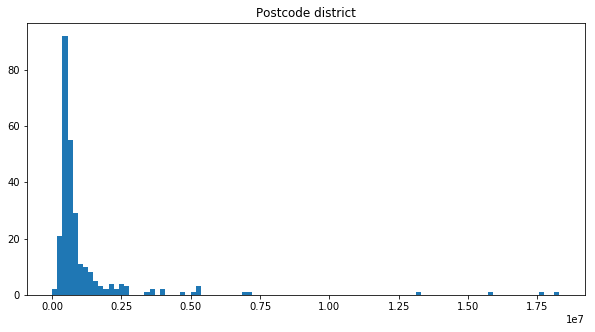

In [25]:
# Price distribution by postcode
postcode_prices = group_transactions(transactions_geo, 'Postcode district')
plot_hit_price(postcode_prices)

In [32]:
constituency_prices = group_transactions(transactions_geo, 'Constituency')
# bins = np.linspace(y.min(), y.max(), 25)
# plt.figure(figsize=(10,5))
# plt.hist(constituency_prices['avg_price'], bins=bins)

In [33]:
constituency_prices.head()

,Constituency,avg_price
0,Barking,309774
1,Battersea,825188
2,Beckenham,550097
3,Bermondsey and Old Southwark,1568092
4,Bethnal Green and Bow,653344


(array([10., 24., 14.,  9.,  6.,  1.,  2.,  0.,  1.,  3.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 309774.        ,  442429.29166667,  575084.58333333,
         707739.875     ,  840395.16666667,  973050.45833333,
        1105705.75      , 1238361.04166667, 1371016.33333333,
        1503671.625     , 1636326.91666667, 1768982.20833333,
        1901637.5       , 2034292.79166667, 2166948.08333333,
        2299603.375     , 2432258.66666667, 2564913.95833333,
        2697569.25      , 2830224.54166667, 2962879.83333333,
        3095535.125     , 3228190.41666667, 3360845.70833333,
        3493501.        ]),
 <a list of 24 Patch objects>)

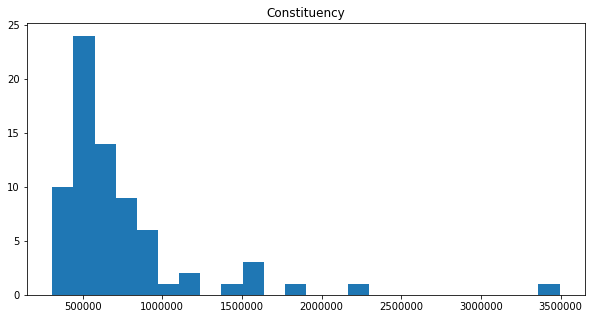

In [34]:
plot_hit_price(constituency_prices)

(array([ 9., 14.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 338586.        ,  551053.45833333,  763520.91666667,
         975988.375     , 1188455.83333333, 1400923.29166667,
        1613390.75      , 1825858.20833333, 2038325.66666667,
        2250793.125     , 2463260.58333333, 2675728.04166667,
        2888195.5       , 3100662.95833333, 3313130.41666667,
        3525597.875     , 3738065.33333333, 3950532.79166667,
        4163000.25      , 4375467.70833333, 4587935.16666667,
        4800402.625     , 5012870.08333333, 5225337.54166667,
        5437805.        ]),
 <a list of 24 Patch objects>)

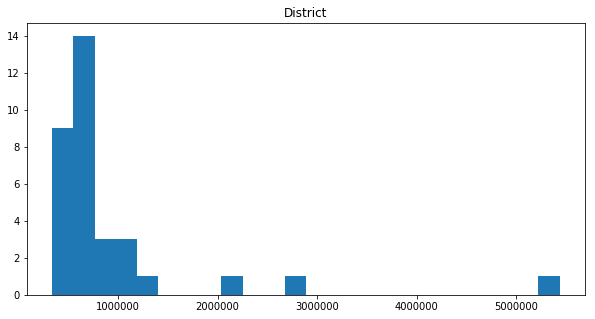

In [35]:
borough_prices = group_transactions(transactions_geo, 'District')
plot_hit_price(borough_prices)

We can see from the charts above that the distribution of house prices follows a fairly normal distribution, but then has long tail skewing the data towards higher values. This is no surprise given the high premium that is placed on prime central london real estate. In order to help group this data better, I will classify the prices into four bands below.

In [36]:
def price_classificaton(frame):
    lower = np.percentile(frame['avg_price'],25)
    median = np.percentile(frame['avg_price'],50)
    upper = np.percentile(frame['avg_price'],75)
    frame.loc[frame['avg_price'] > upper, 'price_band'] = 'expensive' 
    frame.loc[frame['avg_price'] <= upper, 'price_band'] = 'premium' 
    frame.loc[frame['avg_price'] <= median, 'price_band'] = 'mid range' 
    frame.loc[frame['avg_price'] <= lower, 'price_band'] = 'cheap' 
    return frame

In [37]:
postcode_prices = price_classificaton(group_transactions(transactions_geo, 'Postcode district'))

In [38]:
constituency_prices = price_classificaton(group_transactions(transactions_geo, 'Constituency'))

### Use foursquare to get local venues

I wil extract neighbourhood features at two geographical layers, postcode area and constituency. I will repeat the analysis for both to understand what effect if any the geographical proximity of central london postcodes may have. 

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# london_venues_raw = getNearbyVenues(names=districts['Postcode district'],
#                                    latitudes=districts['Latitude'],
#                                    longitudes=districts['Longitude']
#                                   )

In [ ]:
# london_venues_raw.to_csv('london_venues.csv')

In [39]:
london_venues_raw = pd.read_csv('london_venues.csv')

In [ ]:
# # consituencies
# consitutency_venues_raw = getNearbyVenues(names=consituencies['Constituency'],
#                                    latitudes=consituencies['Latitude'],
#                                    longitudes=consituencies['Longitude']
#                                   )

In [ ]:
# consitutency_venues_raw.to_csv('constituency_venues.csv')

In [133]:
london_venues = london_venues_raw.copy()
london_venues.shape

(11150, 8)

In [41]:
london_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,BR1,51.410731,0.019415,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
1,1,BR1,51.410731,0.019415,Anglesey Arms,51.408703,0.020846,Pub
2,2,BR1,51.410731,0.019415,O'Neill's,51.407091,0.015784,Irish Pub
3,3,BR1,51.410731,0.019415,The Lavender House,51.414277,0.019808,Café
4,4,BR1,51.410731,0.019415,Cow and Pig,51.407401,0.016438,English Restaurant


In [42]:
london_venues['Venue Category'].value_counts().head()

Coffee Shop           702
Pub                   671
Hotel                 461
Café                  431
Italian Restaurant    311
Name: Venue Category, dtype: int64

In [43]:
len(london_venues['Venue Category'].unique())

385

As we can see from above there are a lot of features for this dataset (385). This may affect the performance of the clustering algorithm and we may need to carry out some feature engineering to improve this. 

### one hot encoding postcode data

In [54]:
def pre_processing(frame):
    london_one_hot = pd.get_dummies(frame[['Venue Category']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').mean().reset_index()
    return london_grouped_category

In [ ]:
london_grouped = pre_processing(london_venues)
london_grouped.shape

In [ ]:
london_grouped.head()

### summary of top venues

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
def get_top_venues(frame):
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['layer']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    top_venues = pd.DataFrame(columns=columns)
    top_venues['layer'] = frame['layer']

    for ind in np.arange(frame.shape[0]):
        top_venues.iloc[ind, 1:] = return_most_common_venues(frame.iloc[ind, :], num_top_venues)
        
    return top_venues

In [ ]:
neighborhoods_venues_sorted = get_top_venues(london_grouped)
neighborhoods_venues_sorted.shape

In [ ]:
neighborhoods_venues_sorted.head()

### clustering postcode data

In [50]:
def elbow_method(frame):
    elbow_df = frame.drop('layer', 1)
#     elbow_df = frame
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(elbow_df)
        distortions.append(sum(np.min(cdist(elbow_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / elbow_df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('optimal k')
    plt.show()

In [51]:
def kmeans_plot(frame,k):
    hist_plot_df = frame.drop('layer', 1)
#     hist_plot_df = frame
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hist_plot_df)
    plt.title(f'k={k}')
    # plot
    return plt.hist(kmeans.labels_, bins=k)

In [ ]:
elbow_method(london_grouped)

The chart above shows us that there is no obvious optimal point for K, and additional clusters continue to improve the clustering algorithm. This may be due to the fact that there very high number of features in this dataset. I will revisit this once the initial analysis is complete. 

To help further in identifying an optimal k, I will plot the frequency of each cluster below. This will give an insight into how successful the clustering approach has been in finding similarities between neighbourhoods. 

In [ ]:
kmeans_plot(london_grouped, 10)

In [ ]:
kmeans_plot(london_grouped, 7)

In [ ]:
kmeans_plot(london_grouped, 5)

Since adding additonal clusters continues to improve accuracy I will use k = 7 for my analysis, as the historgram plots above indicate that this gives us an additional cluster with subtantial data points, indicating the algorithm has found additional similarities between clusters. 

In [ ]:
# tableau_postcodes = london_grouped.insert(0, 'Cluster Labels', labels)
# london_grouped.to_csv('postcodes_tableau.csv')

In [ ]:
k = 7
grouped_clustering = london_grouped.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
len(kmeans.labels_)

In [ ]:
postcode_map = districts.merge(neighborhoods_venues_sorted, left_on='Postcode district', right_on='layer')

In [ ]:
postcode_map.head()

### Map of london clusters

In [49]:
def cluster_map(frame, k):
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(frame['Latitude'], frame['Longitude'], frame['layer'], frame['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [ ]:
cluster_map(postcode_map,k)

We can see from the map above that the kmeans algorithm has been able to group certain areas of London based on their geographical features. We can look at the most common types of venues in those areas in those neighbourhoods to understand their common features. I will also join the average house price data back onto this data frame so we can get an idea of price bands

In [48]:
def view_df(frame, cluster):
    return frame.loc[frame['Cluster Labels'] == cluster, frame.columns[[0] + list(range(4, frame.shape[1]))]]

In [ ]:
postcode_cluster_prices = postcode_map.merge(postcode_prices, how='left', on='Postcode district')
postcode_cluster_prices.shape
# postcode_cluster_prices.to_csv('postcodes_tableau.csv')

In [ ]:
view_df(postcode_cluster_prices,0)

In [ ]:
view_df(postcode_cluster_prices,1)

In [ ]:
view_df(postcode_cluster_prices,2)

In [ ]:
view_df(postcode_cluster_prices,3)

In [ ]:
view_df(postcode_cluster_prices,4)

In [ ]:
view_df(postcode_cluster_prices,5)

In [ ]:
view_df(postcode_cluster_prices,6)

In [ ]:
postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == i, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head().index

In [ ]:
dataframe[column].value_counts().index.tolist()

In [ ]:
df_top5_venue_counts = pd.DataFrame(columns=['cluster', 'venue', 'count'])
count_list = []
for i in range(7):
    x = pd.DataFrame(columns=['cluster', 'venue', 'count'])
#     count_list.append(
#     postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == i, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head()
#     )
    x['cluster'] = 'cluster {}'.format(i)
    x['venue'] = postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == i, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head().index
    x['count'] = postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == i, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head()[0]
    df_top5_venue_counts = pd.concat([df_top5_venue_counts,x])
    df_top5_venue_counts = df_top5_venue_counts.drop('cluster', 1)

In [ ]:
# df_top5_venue_counts

In [ ]:
df_top5_venue_counts

In [ ]:
postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == 5, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head()

In [ ]:
postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == 6, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head()
# postcode_cluster_prices.stack().value_counts()

### repeating the analysis excluding prime central london real estate

In [109]:
london_venues = london_venues[
    (london_venues['Neighborhood'].str[0]=='E') 
    | (london_venues['Neighborhood'].str[0]=='N')
    | (london_venues['Neighborhood'].str[0]=='S')
    | (london_venues['Neighborhood'].str[0]=='W')
]
london_venues = london_venues[
    (london_venues['Neighborhood'].str[0:2]!='EN')
    & (london_venues['Neighborhood'].str[0:2]!='SM')
    & (london_venues['Neighborhood'].str[0:2]!='WD')
    & (london_venues['Neighborhood'].str[0:2]!='WC')
    & (london_venues['Neighborhood'].str[0:2]!='EC')
]
london_venues.shape

(5990, 8)

In [55]:
london_grouped = pre_processing(london_venues)
london_grouped.shape

(153, 319)

### summary of top venues

In [ ]:
neighborhoods_venues_sorted = get_top_venues(london_grouped)
neighborhoods_venues_sorted.shape

In [ ]:
elbow_method(london_grouped)

In [ ]:
kmeans_plot(london_grouped, 10)

In [ ]:
kmeans_plot(london_grouped, 7)

In [ ]:
kmeans_plot(london_grouped, 5)

In [ ]:
k = 5
grouped_clustering = london_grouped.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
len(kmeans.labels_)

In [ ]:
postcode_map = districts.merge(neighborhoods_venues_sorted, left_on='Postcode district', right_on='layer')

In [ ]:
cluster_map(postcode_map,k)

In [ ]:
postcode_cluster_prices = postcode_map.merge(postcode_prices, how='left', on='Postcode district')
postcode_cluster_prices.shape

In [ ]:
view_df(postcode_cluster_prices,0)

In [ ]:
view_df(postcode_cluster_prices,1)

In [ ]:
view_df(postcode_cluster_prices,2)

In [ ]:
view_df(postcode_cluster_prices,3)

In [ ]:
view_df(postcode_cluster_prices,4)

### Feature engineering before preprocessing to improve clustering

The elbow method charts from above showed us that we cannot find an optimal value for K as the there was no significant elbow point which marked the best value. This is likely due to the fact the dataset currently has a large number of features (385 including outer london and central london postcodes). As we can see from features below, many of these features are very similar and differ due to slight name changes or sub categories. For example, the various different restraunts by world cuisine could be grouped together as restraunts. In this section I will carry out some feature engineering to reduce the number of features by combining these categories, to improve the clustering algorithm. 

In [134]:
london_venues['Venue Category'].unique()

array(['Indian Restaurant', 'Pub', 'Irish Pub', 'Café',
       'English Restaurant', 'Bar', 'Buffet', 'Train Station',
       'Bus Station', 'Lingerie Store', 'Gym / Fitness Center', 'Park',
       'Soccer Stadium', 'Gym', 'Athletics & Sports',
       'Mediterranean Restaurant', 'Diner', 'Fish & Chips Shop',
       'Kebab Restaurant', 'Portuguese Restaurant', 'Coffee Shop',
       'Supermarket', 'Pharmacy', 'Sandwich Place', 'Pizza Place',
       'Movie Theater', 'Grocery Store', 'Italian Restaurant',
       'Pet Store', 'Stationery Store', 'Other Repair Shop', 'Bakery',
       'Home Service', 'Construction & Landscaping', 'Tech Startup',
       'Auto Dealership', 'Golf Course', 'Health & Beauty Service',
       'Fast Food Restaurant', 'Sauna / Steam Room', 'Noodle House',
       'Art Gallery', 'Thai Restaurant', 'Burger Joint',
       'Recording Studio', 'Vietnamese Restaurant',
       'Vegetarian / Vegan Restaurant', 'Cocktail Bar', 'Garden',
       'History Museum', 'Theme Park Ride

In [135]:
len(london_venues['Venue Category'].unique())

385

In [136]:
Restaurant_msk = london_venues['Venue Category'].str.contains('Restaurant')
Bar_msk = london_venues['Venue Category'].str.contains('Bar')
Shop_msk = london_venues['Venue Category'].str.contains('Shop')
Store_msk = london_venues['Venue Category'].str.contains('Store')
Gym_msk = london_venues['Venue Category'].str.contains('Gym')
food_place_msk = london_venues['Venue Category'].str.contains('Place')
museum_msk = london_venues['Venue Category'].str.contains('Museum')

In [137]:
len(london_venues.loc[Shop_msk,'Venue Category'].unique())

45

In [114]:
def feature_engineering(frame):
    Restaurant_msk = frame['Venue Category'].str.contains('Restaurant')
    Bar_msk = frame['Venue Category'].str.contains('Bar')
    Shop_msk = frame['Venue Category'].str.contains('Shop')
    Store_msk = frame['Venue Category'].str.contains('Store')
    Gym_msk = frame['Venue Category'].str.contains('Gym')
    food_place_msk = frame['Venue Category'].str.contains('Place')
    museum_msk = frame['Venue Category'].str.contains('Museum')
    frame.loc[Restaurant_msk, 'Venue Category'] = 'Restaurant'
    frame.loc[Bar_msk, 'Venue Category'] = 'Bar'
    frame.loc[Shop_msk, 'Venue Category'] = 'Shop'
    frame.loc[Store_msk, 'Venue Category'] = 'Store'
    frame.loc[Gym_msk, 'Venue Category'] = 'Gym'
    frame.loc[food_place_msk, 'Venue Category'] = 'Place'
    frame.loc[museum_msk, 'Venue Category'] = 'Museum'
    return frame

In [127]:
london_venues = feature_engineering(london_venues)

In [128]:
len(london_venues['Venue Category'].unique())

198

As we can see from this, the feature engineering has halved the number of features in the dataset, without losing valuable information. Hopefully this will improve clustering. The approach will now be repeated with this dataset.

### Repeating clustering with feature engineered dataset

In [119]:
london_grouped = pre_processing(london_venues)
london_grouped.shape

(153, 152)

In [120]:
neighborhoods_venues_sorted = get_top_venues(london_grouped)
neighborhoods_venues_sorted.shape

(153, 11)

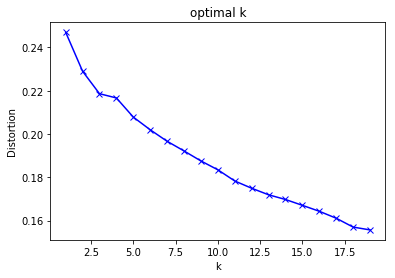

In [121]:
elbow_method(london_grouped)

(array([  2.,  51., 162.,  12.,  15.,   5.,  77.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

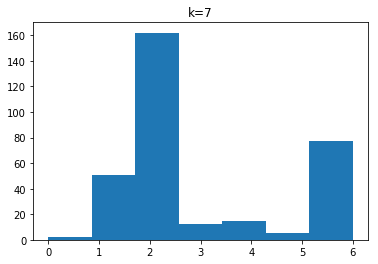

In [88]:
kmeans_plot(london_grouped, 7)

(array([ 12.,  54.,   6.,   4.,   5.,  13., 137.,  79.,  13.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

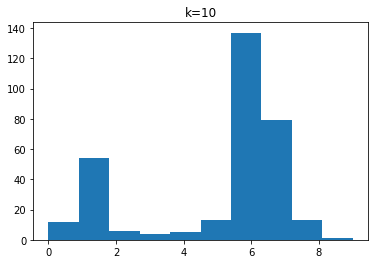

In [86]:
kmeans_plot(london_grouped, 10)

In [89]:
k = 10
grouped_clustering = london_grouped.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
len(kmeans.labels_)

324

In [90]:
postcode_map = districts.merge(neighborhoods_venues_sorted, left_on='Postcode district', right_on='layer')

In [91]:
cluster_map(postcode_map,k)

In [92]:
postcode_cluster_prices = postcode_map.merge(postcode_prices, how='left', on='Postcode district')
postcode_cluster_prices.shape

(324, 17)

In [93]:
view_df(postcode_cluster_prices,0)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
5,BR6,BR6,Pub,Auto Dealership,Home Service,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,590375.0,mid range
10,CR0,CR0,Pub,Bus Stop,Tram Station,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,368049.0,cheap
17,CR7,CR7,Food Service,Pub,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,430310.0,cheap
23,DA15,DA15,Pub,Athletics & Sports,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,402062.0,cheap
35,E13,E13,Pub,Café,Bus Station,Gym,Currency Exchange,Entertainment Service,Fish Market,Creperie,Film Studio,Farmers Market,312171.0,cheap
84,EN2,EN2,Pub,Hotel,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,494554.0,mid range
111,IG9,IG9,Pub,Restaurant,Gym,Creperie,Cricket Ground,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,459500.0,mid range
114,KT19,KT19,Pub,Restaurant,Diner,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,NaN,NaN
121,KT7,KT7,Pub,Hotel,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,NaN,NaN
177,SE1,SE1,Pub,Restaurant,Park,Theater,Shop,Café,Deli / Bodega,Residential Building (Apartment / Condo),Garden,Farm,2276110.0,expensive


In [94]:
view_df(postcode_cluster_prices,1)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
0,BR1,BR1,Restaurant,Pub,Train Station,Bus Station,Store,Café,Bar,Irish Pub,Buffet,Exhibit,714669.0,premium
3,BR4,BR4,Place,Supermarket,Pub,Store,Restaurant,Pharmacy,Design Studio,Farmers Market,Farm,Exhibit,552000.0,mid range
6,BR7,BR7,Pub,Health & Beauty Service,Bar,Golf Course,Yoga Studio,Diner,Fish Market,Film Studio,Farmers Market,Farm,586019.0,mid range
11,CR2,CR2,Platform,Shop,Train Station,Park,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,485007.0,mid range
12,CR3,CR3,Platform,Garden Center,Café,Park,Yoga Studio,Dry Cleaner,Fish Market,Film Studio,Farmers Market,Farm,510333.0,mid range
13,CR4,CR4,Construction & Landscaping,Bus Stop,Dry Cleaner,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,368555.0,cheap
15,CR5,CR5,Park,Bus Stop,Art Gallery,Platform,Shop,Café,Restaurant,Yoga Studio,Film Studio,Farmers Market,562247.0,mid range
16,CR6,CR6,Gastropub,Yoga Studio,Dry Cleaner,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,450000.0,cheap
44,E3,E3,Pub,Store,Locksmith,Bus Stop,Park,Bar,Burger Joint,Cycle Studio,Event Space,Flea Market,437487.0,cheap
46,E5,E5,Store,Pub,Shop,Bar,Park,Gastropub,Burger Joint,Garden,Restaurant,Breakfast Spot,630896.0,premium


In [104]:
view_df(postcode_cluster_prices,2)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
4,BR5,BR5,Construction & Landscaping,Shop,Home Service,Bakery,Tech Startup,Distillery,Fish Market,Film Studio,Farmers Market,Farm,414709.0,cheap
14,CR44,CR44,Store,Home Service,Tram Station,Shop,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,NaN,NaN
45,E4,E4,Home Service,Yoga Studio,Distillery,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,424142.0,cheap
103,IG11,IG11,Construction & Landscaping,Home Service,Restaurant,Park,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,304877.0,cheap
172,RM50,RM50,Racetrack,Home Service,Diner,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,NaN,NaN
209,SM3,SM3,Construction & Landscaping,IT Services,Shop,Home Service,Café,Restaurant,Diner,Film Studio,Farmers Market,Farm,443831.0,cheap


In [96]:
view_df(postcode_cluster_prices,3)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
1,BR2,BR2,Gym,Soccer Stadium,Athletics & Sports,Park,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,489235.0,mid range
95,HA3,HA3,Gym,Park,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,448308.0,cheap
119,KT5,KT5,Gym,Bus Stop,Park,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,665171.0,premium
273,W11,W11,Gym,Indoor Play Area,Shop,Restaurant,Park,Diner,Film Studio,Farmers Market,Farm,Exhibit,2067275.0,expensive


In [97]:
view_df(postcode_cluster_prices,4)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
88,EN6,EN6,Park,Yoga Studio,Food Court,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,NaN,NaN
107,IG5,IG5,Transportation Service,Park,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,555166.0,mid range
113,KT17,KT17,Park,Yoga Studio,Food Court,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,NaN,NaN
159,NW7,NW7,Construction & Landscaping,Park,Food Court,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,589400.0,mid range
180,SE12,SE12,Soccer Field,Park,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,512115.0,mid range


In [98]:
view_df(postcode_cluster_prices,5)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
25,DA17,DA17,Restaurant,Breakfast Spot,Trail,Distillery,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,284425.0,cheap
26,DA18,DA18,Restaurant,Train Station,Trail,Yoga Studio,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,237000.0,cheap
34,E12,E12,Train Station,Restaurant,Gym,Design Studio,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,385272.0,cheap
92,HA0,HA0,Restaurant,Pub,Park,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,686505.0,premium
117,KT3,KT3,Restaurant,Store,Shop,Place,Café,Gym,Supermarket,Platform,Bar,Office,577017.0,mid range
165,RM12,RM12,Gym,Restaurant,Design Studio,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,Entertainment Service,376225.0,cheap
176,RM9,RM9,Store,Restaurant,Yoga Studio,Distillery,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,312380.0,cheap
186,SE18,SE18,Restaurant,Store,Bus Stop,Child Care Service,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,371229.0,cheap
259,UB1,UB1,Restaurant,Shop,Intersection,Place,Store,Supermarket,Food,Currywurst Joint,Cricket Ground,Fish Market,390927.0,cheap
263,UB2,UB2,Restaurant,Store,Hotel,Yoga Studio,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,1032805.0,expensive


In [99]:
view_df(postcode_cluster_prices,6)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
2,BR3,BR3,Restaurant,Shop,Store,Place,Supermarket,Pub,Diner,Pharmacy,Bar,Café,496047.0,mid range
7,BR8,BR8,Diner,Restaurant,Sauna / Steam Room,Yoga Studio,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,845000.0,premium
9,CM23,CM23,Restaurant,Hotel,Pub,Shop,Café,Bar,Garden,Burger Joint,Place,Rock Club,NaN,NaN
18,CR8,CR8,Place,Shop,Restaurant,Platform,Supermarket,Pub,Gym,Pharmacy,Café,Design Studio,839546.0,premium
19,CR9,CR9,Restaurant,Store,Hotel,Shop,Pub,Gym,Platform,Place,Bar,Bookstore,NaN,NaN
31,E1,E1,Restaurant,Shop,Hotel,Pub,Store,Place,Gym,Bakery,Bar,Outdoor Sculpture,714580.0,premium
36,E14,E14,Restaurant,Shop,Place,Park,Plaza,Gym,Bar,Burger Joint,Café,Store,509667.0,mid range
38,E16,E16,Restaurant,Hotel,Café,Gym,Shop,Store,Pub,Bar,Park,Steakhouse,395842.0,cheap
40,E18,E18,Restaurant,Store,Bar,Shop,Supermarket,Café,Multiplex,BBQ Joint,Pharmacy,Place,503071.0,mid range
42,E2,E2,Restaurant,Shop,Bar,Pub,Hotel,Place,Café,Gym,Store,Yoga Studio,471528.0,mid range


In [100]:
view_df(postcode_cluster_prices,7)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
20,CR90,CR90,Store,Shop,Restaurant,Pharmacy,Place,Supermarket,Platform,Pub,Gas Station,Park,NaN,NaN
21,DA1,DA1,Store,Shop,Restaurant,Pub,Gym,Pharmacy,Supermarket,Diner,Farmers Market,Farm,865544.0,premium
22,DA14,DA14,Pub,Bakery,Shop,Store,Pharmacy,Bar,Restaurant,Hotel,Currywurst Joint,Distillery,2643266.0,expensive
24,DA16,DA16,Shop,Restaurant,Supermarket,Pub,Store,Place,Pharmacy,Design Studio,Farm,Exhibit,397298.0,cheap
27,DA5,DA5,Construction & Landscaping,Store,Restaurant,Park,Tennis Court,Distillery,Fish Market,Film Studio,Farmers Market,Farm,429961.0,cheap
28,DA6,DA6,Restaurant,Store,Shop,Pub,Place,Bakery,Recreation Center,Hotel,Supermarket,Pharmacy,412202.0,cheap
32,E10,E10,Park,Farm,Cricket Ground,Hotel,Store,Shop,Restaurant,Fried Chicken Joint,Yoga Studio,Distillery,434559.0,cheap
33,E11,E11,Restaurant,Pub,Café,Store,Shop,Place,Bakery,Music Venue,Metro Station,Bus Stop,622410.0,premium
37,E15,E15,Restaurant,Pub,Shop,Place,Platform,Store,Hotel,Bar,Café,General Entertainment,427562.0,cheap
39,E17,E17,Store,Shop,Place,Restaurant,Pub,Pharmacy,Bakery,Café,Bookstore,Farmers Market,816658.0,premium


In [101]:
view_df(postcode_cluster_prices,8)

,Postcode district,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
29,DA7,DA7,Store,Pub,Post Office,Diner,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,Event Space,434337.0,cheap
30,DA8,DA8,Store,Athletics & Sports,Café,Restaurant,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Film Studio,Farmers Market,311363.0,cheap
47,E6,E6,Store,Park,Gym,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,1304758.0,expensive
86,EN4,EN4,Store,Restaurant,Park,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,655298.0,premium
126,N11,N11,Store,Shop,Metro Station,Bus Stop,Train Station,Bar,Yoga Studio,Fish Market,Film Studio,Farmers Market,497886.0,mid range
170,RM4,RM4,Construction & Landscaping,Store,Food Court,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,595000.0,premium
173,RM6,RM6,Store,Place,Supermarket,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,317613.0,cheap
189,SE2,SE2,Store,Platform,Shop,Supermarket,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,327756.0,cheap
198,SE28,SE28,Store,Breakfast Spot,Bakery,Dry Cleaner,Food,Flea Market,Fish Market,Film Studio,Farmers Market,Farm,488096.0,mid range
202,SE6,SE6,Store,Shop,Restaurant,Yoga Studio,Distillery,Fish Market,Film Studio,Farmers Market,Farm,Exhibit,418832.0,cheap


In [103]:
postcode_cluster_prices.loc[postcode_cluster_prices['Cluster Labels'] == 1, postcode_cluster_prices.columns[list(range(4, postcode_cluster_prices.shape[1]))]].stack().value_counts().head()

Pub               32
Farmers Market    31
Film Studio       28
Store             28
Park              23
dtype: int64

The feature engineering has greatly improved the clustering, we can identify clear characteristics of each cluster group distinc and unique from the others. The addition of the price data also allows us to identify the relative price of similar neighbourhoods side by side. 

### Kmeans at constituency level

In [ ]:
# add information on london zone

In [105]:
def pre_processing(frame):
    london_one_hot = pd.get_dummies(frame[['Venue Category']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').mean().reset_index()
    return london_grouped_category

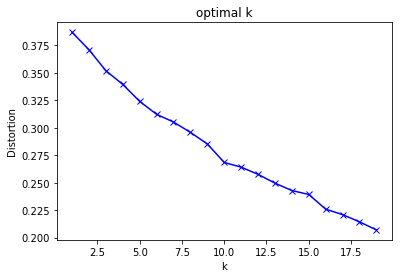

In [106]:
# constits = consitutency_venues_raw.copy()
constits = pd.read_csv('constituency_venues.csv')
constits = feature_engineering(constits)
constits_one_hot = pre_processing(constits)
elbow_method(constits_one_hot)

(array([10., 59.,  1.,  1.,  1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

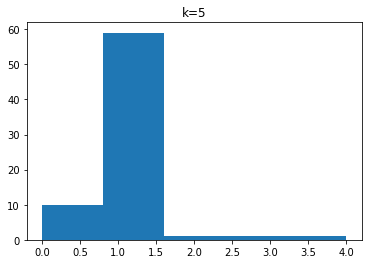

In [107]:
kmeans_plot(constits_one_hot,5)

(array([ 8.,  1.,  3.,  1.,  6.,  2.,  3.,  1., 33.,  1.,  1.,  1.,  7.,
         1.,  3.]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <a list of 15 Patch objects>)

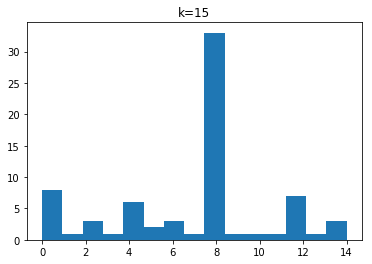

In [108]:
kmeans_plot(constits_one_hot,15)

In [ ]:
constit_venues_sorted = get_top_venues(constits_one_hot)

In [ ]:
k = 15
constits_one_hot = constits_one_hot.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(constits_one_hot)
labels = kmeans.labels_
constit_venues_sorted.insert(0, 'Cluster Labels', labels)

In [ ]:
boroughs_map_df = consituencies.merge(constit_venues_sorted, left_on='Constituency', right_on='layer')

In [ ]:
cluster_map(boroughs_map_df,k)

In [ ]:
borough_cluster_prices = boroughs_map_df.merge(constituency_prices, how='left', on='Constituency')
borough_cluster_prices.shape

In [ ]:
view_df(borough_cluster_prices,0)

In [ ]:
view_df(borough_cluster_prices,3)

In [ ]:
view_df(borough_cluster_prices,4)

In [ ]:
view_df(borough_cluster_prices,6)

In [ ]:
view_df(borough_cluster_prices,8)

In [ ]:
view_df(boroughs_map_df,12)

In [ ]:
view_df(boroughs_map_df,14)

The analysis above shows that using a higher level geography does not provide us with good separation of clusters. There are two reasons for this, 1) the foursquare API extract less feature data due to the broader geographies 2) the higher level geography covers such a diverse range of features that the algorithm is unable to distinguish features amongst them. 

### Kmeans at consituency level with zonal data

In [ ]:
def pre_processing(frame):
    x1 = pd.get_dummies(frame['London zone'])
    x2 = pd.get_dummies(frame['Venue Category'])
    london_one_hot = pd.concat([x1,x2], axis=1)
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').mean().reset_index()
    return london_grouped_category

In [ ]:
london_relevant_columns = london_codes_all[['District','Ward', 'Constituency', 'Postcode district', 'Postcode', 'London zone', 'Latitude', 'Longitude']]

In [ ]:
consituencies = london_relevant_columns.groupby('Constituency').agg({'Latitude':'mean','Longitude':'mean', 'London zone':'median'}).reset_index()
consituencies.head()

In [ ]:
# constits = consitutency_venues_raw.copy()
constits = pd.read_csv('constituency_venues.csv')
constits = constits.merge(consituencies[['Constituency','London zone']], how='left', left_on='Neighborhood', right_on='Constituency')
constits = constits.drop('Constituency', 1)
constits_one_hot = pre_processing(constits)
elbow_method(constits_one_hot)

In [ ]:
constit_venues_sorted = get_top_venues(constits_one_hot)

In [ ]:
kmeans_plot(constits_one_hot,6)

In [ ]:
k = 6
constits_one_hot = constits_one_hot.drop('layer', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(constits_one_hot)
labels = kmeans.labels_
constit_venues_sorted.insert(0, 'Cluster Labels', labels)

In [ ]:
boroughs_map_df = consituencies.merge(constit_venues_sorted, left_on='Constituency', right_on='layer')

In [ ]:
cluster_map(boroughs_map_df,k)

In [ ]:
view_df(boroughs_map_df,0)

In [ ]:
view_df(boroughs_map_df,1)

In [ ]:
view_df(boroughs_map_df,2)

In [ ]:
view_df(boroughs_map_df,3)

In [ ]:
view_df(boroughs_map_df,4)

In [ ]:
view_df(boroughs_map_df,5)

### Kmeans at constituency level with price data

In [ ]:
def pre_processing(frame):
    london_one_hot = pd.get_dummies(frame[['Venue Category']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').sum().reset_index()
    return london_grouped_category

In [ ]:
def pre_processing_price(frame):
    london_one_hot = pd.get_dummies(frame[['price_band']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Constituency']
    return london_one_hot

In [ ]:
constituency_prices = price_classificaton(group_transactions(transactions_geo, 'Constituency'))

In [ ]:
constits = consitutency_venues_raw.copy()
constits_one_hot = pre_processing(constits)
price_one_hot = pre_processing_price(constituency_prices)

factor = 1
columns = price_one_hot['layer']
price_one_hot = price_one_hot[['cheap', 'expensive', 'mid range', 'premium']]/factor
price_one_hot['layer'] = columns
price_one_hot.shape

In [ ]:
price_one_hot.head()

In [ ]:
price_cluster = price_one_hot.merge(constits_one_hot, how='inner', on='layer')
constit_venues_sorted = get_top_venues(constits_one_hot)

In [ ]:
price_cluster = price_cluster.drop('layer', 1)
elbow_method(price_cluster)

In [ ]:
kmeans_plot(price_cluster,6)

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(price_cluster)

In [ ]:
labels = kmeans.labels_
len(labels)
constit_venues_sorted.insert(0, 'Cluster Labels', labels)

In [ ]:
constit_venues_sorted.head()

In [ ]:
x = rejoin_clusters(consituencies,constit_venues_sorted)
constituency_prices.rename(columns={'Constituency':'layer'}, inplace=True)
final_df = x.merge(constituency_prices, on='layer')

In [ ]:
final_df.head()

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kcluster_price)
ys = [i + x + (i*x)**2 for i in range(kcluster_price)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, band, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['layer'], final_df['price_band'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) +'-' + str(band) + ' ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 0, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 1, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 2, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 3, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 4, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In [ ]:
final_df.loc[final_df['Cluster Labels'] == 5, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

In order to evaluate how local venues may affect house prices I need to merge the prices data (numerical) with venue data (categorical) and evaluate this together in a classification model. The data must be pre processed and normalised, however there is a step of normalisatoin already in place for the categorical data where i have grouped by the mean of frequency of each occurence

In [ ]:
from sklearn import preprocessing

In [ ]:
london_grouped.shape

In [ ]:
# london_grouped_for_price = london_grouped.copy()

Aggregating the feature data set by summing the total to obtain the frequency of occurence, so this can be used with the preprocessing libraries

In [ ]:
london_grouped_for_price = london_one_hot.groupby('Postcode district').sum().reset_index()

obtaining target prediction variable for the feature set

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [ ]:
prices_venue = avg_prices.merge(london_grouped_for_price[['Postcode district']], how='right', on='Postcode district')
y = prices_venue['avg_price']
y.shape

In [ ]:
X = london_grouped_for_price.copy().drop('Postcode district', 1)

In [ ]:
# X = X.replace([np.inf, -np.inf], np.nan)
# X[X.isna().any(axis=1)]
# X.shape

using PCA to reduce elements

In [ ]:
# X = PCA(n_components=2).fit_transform(X)

In [ ]:
# y = np.array(y)

In [ ]:
# X = preprocessing.StandardScaler().fit(X).transform(X)
# y = y.reshape(-1, 1)
# y = preprocessing.StandardScaler().fit(y).transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [ ]:
# plt.hist(X, bins='auto')

In [ ]:
# k = 4
# neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
# yhat = neigh.predict(X_test)
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [ ]:
# k = 4
# neigh = KMeans(k).fit_transform(X_train)
# yhat = neigh.predict(X_test)
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [ ]:
# Ks = 20
# mean_acc = np.zeros((Ks-1))
# std_acc = np.zeros((Ks-1))
# ConfustionMx = [];
# for n in range(1,Ks):
    
#     #Train Model and Predict  
#     neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
#     yhat=neigh.predict(X_test)
#     mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
#     std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# plt.plot(range(1,Ks),mean_acc,'g')
# plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
# plt.legend(('Accuracy ', '+/- 3xstd'))
# plt.ylabel('Accuracy ')
# plt.xlabel('(K)')
# plt.tight_layout()
# plt.show()
# print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

## Regression analysis

In [ ]:
X = london_grouped_for_price.copy().drop('Postcode district', 1)
prices_venue = avg_prices.merge(london_grouped_for_price[['Postcode district']], how='right', on='Postcode district')
y = prices_venue['avg_price']
y.shape

In [ ]:
# from sklearn import linear_model
# regr = linear_model.LinearRegression()
# x = np.asanyarray(X)
# y = np.asanyarray(y)
# regr.fit (x, y)
# # The coefficients
# print ('Coefficients: ', regr.coef_)

rejoining clusters with price data to see if this has any indication of value

In [ ]:
#Find correlation for numeric variables

target = prices_venue['avg_price']

corr = train.corr()
corr_abs = corr.abs()

nr_num_cols = len(num_feat)

ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]
print(ser_corr)

In [ ]:
# Highest value Frequency percentage in categorical variables 
for i in list(cat_feat):
    pct = df[i].value_counts()[0] / 2919
    print('Highest value Percentage of {}: {:3f}'.format(i, pct))

In [ ]:
# Highest value Frequency percentage in categorical variables 
for i in list(cat_feat):
    pct = df[i].value_counts()[0] / 2919
    print('Highest value Percentage of {}: {:3f}'.format(i, pct))